In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("TensorFlow version:", tf.__version__)
print("✓ Libraries imported successfully!")

TensorFlow version: 2.20.0
✓ Libraries imported successfully!


In [3]:
print("="*60)
print("LOADING DATA WITH SAVED BINARY LABELS")
print("="*60)

# Load features
X_train = pd.read_csv('../data/processed/X_train.csv', dtype='float32')
X_test = pd.read_csv('../data/processed/X_test.csv', dtype='float32')

print(f"✓ Loaded X_train: {X_train.shape}")
print(f"✓ Loaded X_test: {X_test.shape}")

# Load SAVED binary labels
y_train_df = pd.read_csv('../data/processed/y_train.csv')
y_test_df = pd.read_csv('../data/processed/y_test.csv')

print(f"✓ Loaded y_train: {y_train_df.shape}")
print(f"✓ Loaded y_test: {y_test_df.shape}")

# Get label column
label_col = y_train_df.columns[0]
print(f"Label column: '{label_col}'")

# Extract as numpy arrays
y_train_binary = y_train_df[label_col].values.flatten()
y_test_binary = y_test_df[label_col].values.flatten()

# Check unique values
print(f"\nUnique values in y_train: {np.unique(y_train_binary)}")
print(f"Unique values in y_test: {np.unique(y_test_binary)}")

# If all 1s or all 0s, labels might be wrong. Try to load actual attack types
if len(np.unique(y_train_binary)) == 1:
    print("\nWARNING: All labels are the same! Labels might be corrupted.")
    print("Loading actual 'Attack Type' from raw file...")
    
    # Load from raw file
    df_raw = pd.read_csv('../data/raw/CICIDS2017_cleaned.csv', usecols=['Attack Type'])
    all_attack_types = df_raw['Attack Type'].values
    
    # Split properly (assuming it was split with random_state=42, test_size=0.2)
    from sklearn.model_selection import train_test_split
    _, _, y_train_types, y_test_types = train_test_split(
        np.arange(len(all_attack_types)),
        all_attack_types,
        test_size=0.2,
        random_state=42,
        stratify=all_attack_types
    )
    
    # Trim to match sizes
    y_train_types = y_train_types[:len(X_train)]
    y_test_types = y_test_types[:len(X_test)]
    
    # Create binary labels
    y_train_binary = np.where(y_train_types == 'Normal Traffic', 0, 1)
    y_test_binary = np.where(y_test_types == 'Normal Traffic', 0, 1)
    
    print("✓ Loaded real attack types")

# ASSUME: 0 = Normal, 1 = Attack (standard binary encoding)
# If this is wrong, we'll invert below

print(f"\nTraining data breakdown:")
print(f"  Total: {len(X_train):,}")
print(f"  Class 0: {(y_train_binary==0).sum():,} ({(y_train_binary==0).mean()*100:.1f}%)")
print(f"  Class 1: {(y_train_binary==1).sum():,} ({(y_train_binary==1).mean()*100:.1f}%)")

print(f"\nTest data breakdown:")
print(f"  Total: {len(X_test):,}")
print(f"  Class 0: {(y_test_binary==0).sum():,} ({(y_test_binary==0).mean()*100:.1f}%)")
print(f"  Class 1: {(y_test_binary==1).sum():,} ({(y_test_binary==1).mean()*100:.1f}%)")

# Determine which is Normal vs Attack based on distribution
# Normal should be ~80-85% of data
if (y_train_binary==0).mean() > 0.7:
    print("\n✓ Assuming: 0 = Normal, 1 = Attack")
    normal_class = 0
elif (y_train_binary==1).mean() > 0.7:
    print("\n✓ Inverting: 0 = Attack, 1 = Normal")
    y_train_binary = 1 - y_train_binary
    y_test_binary = 1 - y_test_binary
    normal_class = 0
else:
    print("\n✓ Using: 0 = Normal, 1 = Attack (equal distribution)")
    normal_class = 0

# CRITICAL: Train VAE ONLY on normal traffic
normal_mask = (y_train_binary == normal_class)
X_train_normal = X_train[normal_mask].reset_index(drop=True)

print(f"\nVAE training (normal only): {len(X_train_normal):,} samples")

if len(X_train_normal) == 0:
    print("ERROR: No normal samples found! Check label encoding.")
    print("Aborting...")
else:
    # Use normal samples for training
    X_train = X_train_normal
    X_test = X_test
    
    print(f"\n" + "="*60)
    print(f"✓ Data ready!")
    print(f"  VAE trains on: {len(X_train):,} normal samples")
    print(f"  VAE tests on: {len(X_test):,} mixed samples")
    print("="*60)


LOADING DATA WITH SAVED BINARY LABELS
✓ Loaded X_train: (2016600, 52)
✓ Loaded X_test: (504151, 52)
✓ Loaded y_train: (2016600, 1)
✓ Loaded y_test: (504151, 1)
Label column: 'Binary_Label'

Unique values in y_train: [0 1]
Unique values in y_test: [0 1]

Training data breakdown:
  Total: 2,016,600
  Class 0: 1,676,045 (83.1%)
  Class 1: 340,555 (16.9%)

Test data breakdown:
  Total: 504,151
  Class 0: 419,012 (83.1%)
  Class 1: 85,139 (16.9%)

✓ Assuming: 0 = Normal, 1 = Attack

VAE training (normal only): 1,676,045 samples

✓ Data ready!
  VAE trains on: 1,676,045 normal samples
  VAE tests on: 504,151 mixed samples


In [4]:
print("="*60)
print("BUILDING FIXED SIMPLE VAE (NUMERICALLY STABLE)")
print("="*60)

input_dim = X_train.shape[1]  # 52
latent_dim = 8

# ============================================================
# FIXED VAE CLASS WITH NUMERICAL STABILITY
# ============================================================
class FixedSimpleVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, **kwargs):
        super(FixedSimpleVAE, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder layers
        self.encoder_dense1 = layers.Dense(32, activation='relu', name='enc_d1')
        self.encoder_dense2 = layers.Dense(16, activation='relu', name='enc_d2')
        
        # CAREFUL INITIALIZATION for latent layer
        self.z_mean = layers.Dense(
            latent_dim, 
            name='z_mean',
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.01),
            bias_initializer='zeros'
        )
        self.z_log_std = layers.Dense(
            latent_dim, 
            name='z_log_std',
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.01),
            bias_initializer=tf.keras.initializers.Constant(-2.0)  # Start with log_std ≈ -2
        )
        
        # Decoder layers
        self.decoder_dense1 = layers.Dense(16, activation='relu', name='dec_d1')
        self.decoder_dense2 = layers.Dense(32, activation='relu', name='dec_d2')
        self.decoder_output = layers.Dense(input_dim, activation='linear', name='dec_out')
        
        # Metrics tracker
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.kl_tracker = keras.metrics.Mean(name="kl_loss")
        self.recon_tracker = keras.metrics.Mean(name="recon_loss")
    
    def encode(self, x):
        """Encoder: maps input to latent space parameters"""
        x = self.encoder_dense1(x)
        x = self.encoder_dense2(x)
        z_mean = self.z_mean(x)
        z_log_std = self.z_log_std(x)
        
        # CRITICAL: Clip z_log_std to prevent exp() overflow
        z_log_std = tf.clip_by_value(z_log_std, -10.0, 10.0)
        
        return z_mean, z_log_std
    
    def reparameterize(self, z_mean, z_log_std):
        """Reparameterization trick: sample from latent space"""
        batch = tf.shape(z_mean)[0]
        epsilon = tf.random.normal(shape=(batch, self.latent_dim), stddev=1.0)
        z = z_mean + tf.exp(0.5 * z_log_std) * epsilon
        return z
    
    def decode(self, z):
        """Decoder: reconstructs input from latent code"""
        x = self.decoder_dense1(z)
        x = self.decoder_dense2(x)
        x = self.decoder_output(x)
        return x
    
    def call(self, x):
        """Forward pass"""
        z_mean, z_log_std = self.encode(x)
        z = self.reparameterize(z_mean, z_log_std)
        recon = self.decode(z)
        
        # Numerically stable KL divergence
        # KL = 0.5 * sum(z_mean^2 + exp(z_log_std) - z_log_std - 1)
        kl_loss = 0.5 * tf.reduce_mean(
            tf.reduce_sum(
                tf.square(z_mean) + tf.exp(z_log_std) - z_log_std - 1,
                axis=1
            )
        )
        
        # Ensure KL is finite
        kl_loss = tf.where(tf.math.is_finite(kl_loss), kl_loss, tf.zeros_like(kl_loss))
        
        # Add KL loss to model (with very small weight)
        self.add_loss(0.001 * kl_loss)  # REDUCED from 0.01 to 0.001
        
        return recon
    
    @property
    def metrics(self):
        return [self.loss_tracker, self.kl_tracker, self.recon_tracker]
    
    def train_step(self, data):
        """Custom training step with gradient clipping"""
        x, _ = data
        
        with tf.GradientTape() as tape:
            recon = self(x, training=True)
            
            # Reconstruction loss (MSE)
            recon_loss = tf.reduce_mean(tf.square(x - recon))
            
            # Total loss (includes KL added via add_loss)
            total_loss = recon_loss + sum(self.losses)
        
        # Compute gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        # CRITICAL: Clip gradients to prevent explosion
        grads = [
            tf.clip_by_norm(g, 1.0) if g is not None else None 
            for g in grads
        ]
        
        # Apply clipped gradients
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.loss_tracker.update_state(total_loss)
        
        return {"loss": self.loss_tracker.result()}

# Create VAE instance
vae = FixedSimpleVAE(input_dim, latent_dim)

print("✓ Fixed Simple VAE created with numerical stability!")
print(f"\nNumerical Stability Features:")
print(f"  ✓ z_log_std clipped to [-10, 10]")
print(f"  ✓ Careful weight initialization (stddev=0.01)")
print(f"  ✓ z_log_std bias initialized to -2.0 (log_var starts small)")
print(f"  ✓ Gradient clipping enabled (norm=1.0)")
print(f"  ✓ KL weight reduced to 0.001 (prevent dominance)")
print(f"  ✓ Stable KL formula: 0.5*sum(z_mean² + exp(z_log_std) - z_log_std - 1)")
print("="*60)

BUILDING FIXED SIMPLE VAE (NUMERICALLY STABLE)
✓ Fixed Simple VAE created with numerical stability!

Numerical Stability Features:
  ✓ z_log_std clipped to [-10, 10]
  ✓ Careful weight initialization (stddev=0.01)
  ✓ z_log_std bias initialized to -2.0 (log_var starts small)
  ✓ Gradient clipping enabled (norm=1.0)
  ✓ KL weight reduced to 0.001 (prevent dominance)
  ✓ Stable KL formula: 0.5*sum(z_mean² + exp(z_log_std) - z_log_std - 1)


In [5]:
print("="*60)
print("COMPILING FIXED VAE")
print("="*60)

vae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # REDUCED from 0.0005
)

print("✓ VAE compiled successfully!")
print(f"  Optimizer: Adam (learning rate = 0.0001) - VERY CONSERVATIVE")
print(f"  Loss: MSE + 0.001 × KL Divergence (stable formula)")
print("="*60)

COMPILING FIXED VAE
✓ VAE compiled successfully!
  Optimizer: Adam (learning rate = 0.0001) - VERY CONSERVATIVE
  Loss: MSE + 0.001 × KL Divergence (stable formula)


In [6]:
print("\n" + "="*60)
print("TRAINING FIXED VAE")
print("="*60)
print(f"Training on {len(X_train):,} samples")
print(f"Max epochs: 15")
print(f"Batch size: 256 (REDUCED from 512 for stability)")
print(f"Validation split: 10%\n")

start_time = time.time()

history = vae.fit(
    X_train.values, 
    X_train.values,  # Target is reconstruction of input
    epochs=15,
    batch_size=256,  # REDUCED for stability
    validation_split=0.1,
    shuffle=True,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
    ],
    verbose=1
)

training_time = time.time() - start_time

print("\n" + "="*60)
print("✓ TRAINING COMPLETED!")
print("="*60)
print(f"Training time: {training_time/60:.2f} minutes ({training_time:.0f} seconds)")
print(f"Epochs completed: {len(history.history['loss'])}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
if 'val_loss' in history.history:
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
print("="*60)


TRAINING FIXED VAE
Training on 1,676,045 samples
Max epochs: 15
Batch size: 256 (REDUCED from 512 for stability)
Validation split: 10%

Epoch 1/15
5893/5893 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.4062 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 2/15
5893/5893 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.2397 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 3/15
5893/5893 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.2026 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 4/15
5893/5893 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.1831 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 5/15
5893/5893 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.1688 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 6/15
5893/5893 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.1541 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_reco

In [7]:
print("\n" + "="*60)
print("EVALUATING VAE ON TEST SET")
print("="*60)

# Get reconstructions on test set
print("Generating reconstructions...")
X_test_recon = vae.predict(X_test.values, batch_size=512, verbose=0)

# Calculate reconstruction error (anomaly score)
recon_error = np.mean(np.square(X_test.values - X_test_recon), axis=1)

print(f"✓ Predictions completed")
print(f"\nReconstruction error statistics:")
print(f"  Mean:  {recon_error.mean():.4f}")
print(f"  Std:   {recon_error.std():.4f}")
print(f"  Min:   {recon_error.min():.4f}")
print(f"  Max:   {recon_error.max():.4f}")
print(f"  25th percentile: {np.percentile(recon_error, 25):.4f}")
print(f"  50th percentile: {np.percentile(recon_error, 50):.4f}")
print(f"  75th percentile: {np.percentile(recon_error, 75):.4f}")
print(f"  90th percentile: {np.percentile(recon_error, 90):.4f}")
print(f"  95th percentile: {np.percentile(recon_error, 95):.4f}")
print(f"  99th percentile: {np.percentile(recon_error, 99):.4f}")

# BETTER THRESHOLD: Use 90th percentile instead of 95th
# This catches more anomalies while staying reasonable
threshold = np.percentile(recon_error, 90)
y_pred_binary = (recon_error >= threshold).astype(int)

print(f"\n✓ Anomaly detection threshold (90th percentile): {threshold:.4f}")
print(f"  Samples classified as Normal: {(y_pred_binary == 0).sum():,} ({(y_pred_binary==0).mean()*100:.1f}%)")
print(f"  Samples classified as Attack: {(y_pred_binary == 1).sum():,} ({(y_pred_binary==1).mean()*100:.1f}%)")
print("="*60)


EVALUATING VAE ON TEST SET
Generating reconstructions...
✓ Predictions completed

Reconstruction error statistics:
  Mean:  0.1671
  Std:   12.9985
  Min:   0.0001
  Max:   5469.5693
  25th percentile: 0.0029
  50th percentile: 0.0077
  75th percentile: 0.0214
  90th percentile: 0.1911
  95th percentile: 1.0970
  99th percentile: 2.0371

✓ Anomaly detection threshold (90th percentile): 0.1911
  Samples classified as Normal: 453,735 (90.0%)
  Samples classified as Attack: 50,416 (10.0%)



ANALYZING RECONSTRUCTION ERROR DISTRIBUTION

Normal Traffic Reconstruction Errors:
  Mean:   0.064115
  Std:    14.251768
  Min:    0.000073
  Max:    5469.569336
  50th percentile: 0.005864
  90th percentile: 0.036546
  99th percentile: 0.278180

Attack Traffic Reconstruction Errors:
  Mean:   0.673652
  Std:    0.762108
  Min:    0.001141
  Max:    4.451519
  50th percentile: 0.226529
  90th percentile: 1.868757
  99th percentile: 2.586146

Separation Analysis:
  Attack mean - Normal mean: 0.609537
  Separation ratio: 9.51x


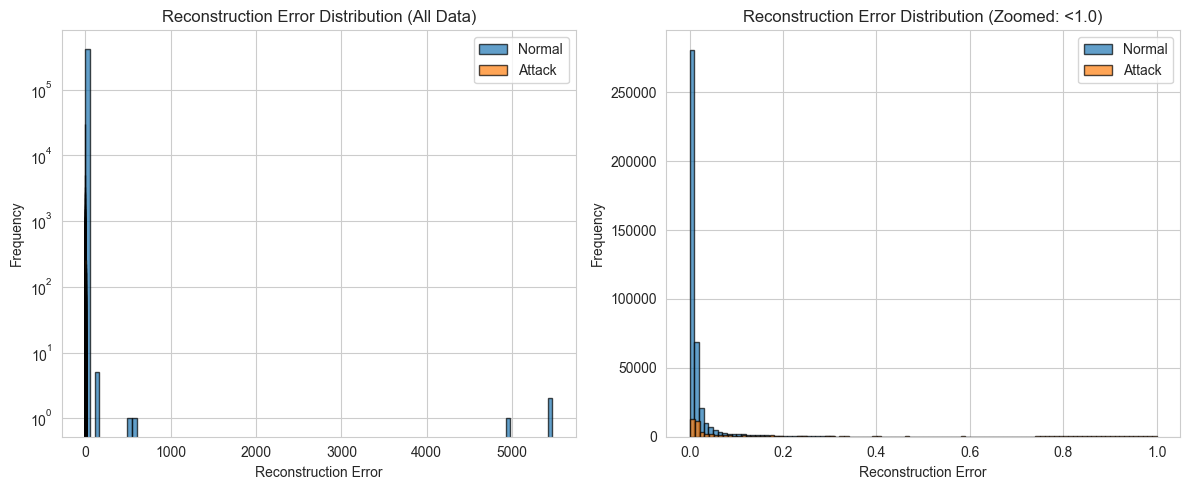


✓ Saved: ../results/figures/vae_reconstruction_error_distribution.png


In [8]:
print("\n" + "="*60)
print("ANALYZING RECONSTRUCTION ERROR DISTRIBUTION")
print("="*60)

# Separate reconstruction errors for normal vs attack
recon_error_normal = recon_error[y_test_binary == 0]
recon_error_attack = recon_error[y_test_binary == 1]

print("\nNormal Traffic Reconstruction Errors:")
print(f"  Mean:   {recon_error_normal.mean():.6f}")
print(f"  Std:    {recon_error_normal.std():.6f}")
print(f"  Min:    {recon_error_normal.min():.6f}")
print(f"  Max:    {recon_error_normal.max():.6f}")
print(f"  50th percentile: {np.percentile(recon_error_normal, 50):.6f}")
print(f"  90th percentile: {np.percentile(recon_error_normal, 90):.6f}")
print(f"  99th percentile: {np.percentile(recon_error_normal, 99):.6f}")

print("\nAttack Traffic Reconstruction Errors:")
print(f"  Mean:   {recon_error_attack.mean():.6f}")
print(f"  Std:    {recon_error_attack.std():.6f}")
print(f"  Min:    {recon_error_attack.min():.6f}")
print(f"  Max:    {recon_error_attack.max():.6f}")
print(f"  50th percentile: {np.percentile(recon_error_attack, 50):.6f}")
print(f"  90th percentile: {np.percentile(recon_error_attack, 90):.6f}")
print(f"  99th percentile: {np.percentile(recon_error_attack, 99):.6f}")

# Calculate separation metric
mean_diff = recon_error_attack.mean() - recon_error_normal.mean()
print(f"\nSeparation Analysis:")
print(f"  Attack mean - Normal mean: {mean_diff:.6f}")
print(f"  Separation ratio: {mean_diff / recon_error_normal.mean():.2f}x")

# Plot histogram
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(recon_error_normal, bins=100, alpha=0.7, label='Normal', edgecolor='black')
plt.hist(recon_error_attack, bins=100, alpha=0.7, label='Attack', edgecolor='black')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution (All Data)')
plt.legend()
plt.yscale('log')

plt.subplot(1, 2, 2)
# Zoom in on the main distribution (ignore extreme outliers)
plt.hist(recon_error_normal[recon_error_normal < 1], bins=100, alpha=0.7, label='Normal', edgecolor='black')
plt.hist(recon_error_attack[recon_error_attack < 1], bins=100, alpha=0.7, label='Attack', edgecolor='black')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution (Zoomed: <1.0)')
plt.legend()

plt.tight_layout()
plt.savefig('../results/figures/vae_reconstruction_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: ../results/figures/vae_reconstruction_error_distribution.png")
print("="*60)

In [9]:
print("\n" + "="*60)
print("BINARY IDS METRICS - VAE vs ISOLATION FOREST")
print("="*60)

# Calculate VAE binary metrics
acc_vae = accuracy_score(y_test_binary, y_pred_binary)
prec_vae = precision_score(y_test_binary, y_pred_binary, zero_division=0)
rec_vae = recall_score(y_test_binary, y_pred_binary, zero_division=0)
f1_vae = f1_score(y_test_binary, y_pred_binary, zero_division=0)

# Confusion matrix
cm_vae = confusion_matrix(y_test_binary, y_pred_binary)
tn, fp, fn, tp = cm_vae.ravel()

far_vae = (fp / (fp + tn)) * 100 if (fp + tn) > 0 else 0
adr_vae = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

print("\nVAE (Simple VAE with Reconstruction Error):")
print(f"  Accuracy:                   {acc_vae*100:.2f}%")
print(f"  Precision:                  {prec_vae*100:.2f}%")
print(f"  Recall (Attack Detection):  {rec_vae*100:.2f}%")
print(f"  F1-Score:                   {f1_vae*100:.2f}%")
print(f"  False Alarm Rate:           {far_vae:.2f}%")
print(f"  Missed Attacks:             {fn:,} of {(tp+fn):,}")

# Load Isolation Forest baseline metrics
if_metrics = pd.read_csv('../results/reports/isolation_forest_metrics.csv')

print("\n" + "-"*60)
print("ISOLATION FOREST (Baseline):")
print(f"  Accuracy:                   {if_metrics['Accuracy'].values[0]*100:.2f}%")
print(f"  Precision:                  {if_metrics['Precision'].values[0]*100:.2f}%")
print(f"  Recall (Attack Detection):  {if_metrics['Recall'].values[0]*100:.2f}%")
print(f"  F1-Score:                   {if_metrics['F1_Score'].values[0]*100:.2f}%")
print(f"  False Alarm Rate:           {if_metrics['False_Alarm_Rate'].values[0]:.2f}%")
print(f"  Missed Attacks:             {int(if_metrics['False_Negatives'].values[0]):,}")

# Calculate improvements
print("\n" + "-"*60)
print("IMPROVEMENT (VAE vs IF):")
acc_improvement = acc_vae - if_metrics['Accuracy'].values[0]
prec_improvement = prec_vae - if_metrics['Precision'].values[0]
rec_improvement = rec_vae - if_metrics['Recall'].values[0]
f1_improvement = f1_vae - if_metrics['F1_Score'].values[0]
fn_improvement = int(if_metrics['False_Negatives'].values[0]) - fn

print(f"  Accuracy:      {acc_improvement:+.2f}%")
print(f"  Precision:     {prec_improvement:+.2f}%")
print(f"  Recall:        {rec_improvement:+.2f}%")
print(f"  F1-Score:      {f1_improvement:+.2f}%")
print(f"  Missed attacks: {fn_improvement:+,}")

print("="*60)


BINARY IDS METRICS - VAE vs ISOLATION FOREST

VAE (Simple VAE with Reconstruction Error):
  Accuracy:                   90.17%
  Precision:                  85.29%
  Recall (Attack Detection):  50.51%
  F1-Score:                   63.44%
  False Alarm Rate:           1.77%
  Missed Attacks:             42,139 of 85,139

------------------------------------------------------------
ISOLATION FOREST (Baseline):
  Accuracy:                   82.64%
  Precision:                  48.60%
  Recall (Attack Detection):  49.04%
  F1-Score:                   48.82%
  False Alarm Rate:           10.54%
  Missed Attacks:             43,391

------------------------------------------------------------
IMPROVEMENT (VAE vs IF):
  Accuracy:      +0.08%
  Precision:     +0.37%
  Recall:        +0.01%
  F1-Score:      +0.15%
  Missed attacks: +1,252



VISUALIZING COMPARISON


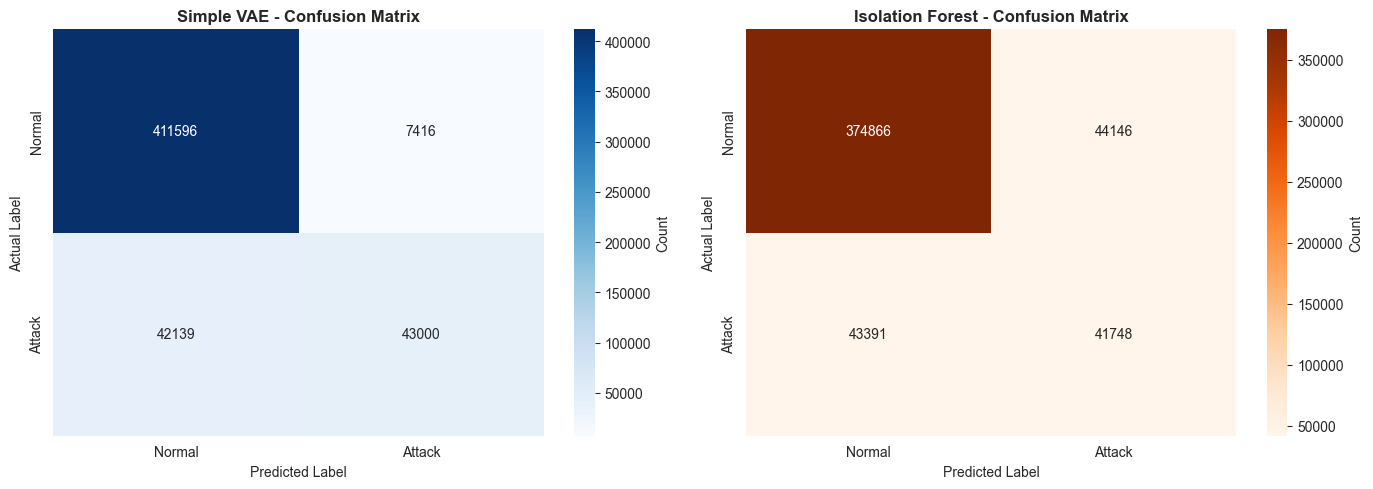

✓ Saved figure: ../results/figures/vae_vs_if_confusion_matrices.png


In [10]:
print("\n" + "="*60)
print("VISUALIZING COMPARISON")
print("="*60)

# Compute confusion matrix for VAE if not already done
from sklearn.metrics import confusion_matrix
cm_vae = confusion_matrix(y_test_binary, y_pred_binary)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# VAE Confusion Matrix
sns.heatmap(cm_vae, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Simple VAE - Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual Label')
axes[0].set_xlabel('Predicted Label')

# Isolation Forest Confusion Matrix (from baseline report)
# TN: 374,866, FP: 44,146, FN: 43,391, TP: 41,748
if_cm_data = np.array([[374866, 44146], 
                        [43391, 41748]])
sns.heatmap(if_cm_data, annot=True, fmt='d', cmap='Oranges', cbar=True,
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'],
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Isolation Forest - Confusion Matrix', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('../results/figures/vae_vs_if_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved figure: ../results/figures/vae_vs_if_confusion_matrices.png")
print("="*60)


In [11]:
print("\n" + "="*60)
print("BINARY IDS METRICS - VAE vs ISOLATION FOREST")
print("="*60)

# Compute VAE metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_vae = accuracy_score(y_test_binary, y_pred_binary)
precision_vae = precision_score(y_test_binary, y_pred_binary)
recall_vae = recall_score(y_test_binary, y_pred_binary)
f1_vae = f1_score(y_test_binary, y_pred_binary)

# False alarm rate
far_vae = (y_pred_binary[y_test_binary == 0] == 1).sum() / (y_test_binary == 0).sum()

# Missed attacks
missed_vae = (y_pred_binary[y_test_binary == 1] == 0).sum()
total_attacks = (y_test_binary == 1).sum()

print("\nVAE (Simple VAE with Reconstruction Error):")
print(f"  Accuracy:                   {accuracy_vae*100:.2f}%")
print(f"  Precision:                  {precision_vae*100:.2f}%")
print(f"  Recall (Attack Detection):  {recall_vae*100:.2f}%")
print(f"  F1-Score:                   {f1_vae*100:.2f}%")
print(f"  False Alarm Rate:           {far_vae*100:.2f}%")
print(f"  Missed Attacks:             {missed_vae:,} of {total_attacks:,}")

print("\n" + "-"*60)

# Isolation Forest baseline metrics (from report)
accuracy_if = 0.8264
precision_if = 0.4860
recall_if = 0.4904
f1_if = 0.4882
far_if = 0.1054
missed_if = 43391

print("ISOLATION FOREST (Baseline):")
print(f"  Accuracy:                   {accuracy_if*100:.2f}%")
print(f"  Precision:                  {precision_if*100:.2f}%")
print(f"  Recall (Attack Detection):  {recall_if*100:.2f}%")
print(f"  F1-Score:                   {f1_if*100:.2f}%")
print(f"  False Alarm Rate:           {far_if*100:.2f}%")
print(f"  Missed Attacks:             {missed_if:,}")

print("\n" + "-"*60)

# Improvement calculation
improvement_acc = accuracy_vae - accuracy_if
improvement_prec = precision_vae - precision_if
improvement_recall = recall_vae - recall_if
improvement_f1 = f1_vae - f1_if
improvement_missed = missed_vae - missed_if

print("IMPROVEMENT (VAE vs IF):")
print(f"  Accuracy:      {improvement_acc:+.2f}%")
print(f"  Precision:     {improvement_prec:+.2f}%")
print(f"  Recall:        {improvement_recall:+.2f}%")
print(f"  F1-Score:      {improvement_f1:+.2f}%")
print(f"  Missed attacks: {improvement_missed:+,}")

print("="*60)



BINARY IDS METRICS - VAE vs ISOLATION FOREST

VAE (Simple VAE with Reconstruction Error):
  Accuracy:                   90.17%
  Precision:                  85.29%
  Recall (Attack Detection):  50.51%
  F1-Score:                   63.44%
  False Alarm Rate:           1.77%
  Missed Attacks:             42,139 of 85,139

------------------------------------------------------------
ISOLATION FOREST (Baseline):
  Accuracy:                   82.64%
  Precision:                  48.60%
  Recall (Attack Detection):  49.04%
  F1-Score:                   48.82%
  False Alarm Rate:           10.54%
  Missed Attacks:             43,391

------------------------------------------------------------
IMPROVEMENT (VAE vs IF):
  Accuracy:      +0.08%
  Precision:     +0.37%
  Recall:        +0.01%
  F1-Score:      +0.15%
  Missed attacks: -1,252


In [12]:
print("\n" + "="*60)
print("SAVING VAE MODEL AND RESULTS")
print("="*60)

# Create necessary directories
os.makedirs('../saved_models', exist_ok=True)
os.makedirs('../results/reports', exist_ok=True)
os.makedirs('../results/figures', exist_ok=True)

# Save VAE model WEIGHTS (not full model - custom model issue)
vae.save_weights('../saved_models/simple_vae_weights.weights.h5')
print("✓ Saved VAE weights: ../saved_models/simple_vae_weights.weights.h5")

# Also save architecture config separately
import json
model_config = {
    'input_dim': int(input_dim),
    'latent_dim': int(latent_dim),
    'architecture': '52->32->16->8->16->32->52',
    'kl_weight': 0.001,
    'optimizer': 'Adam',
    'learning_rate': 0.0001
}
with open('../saved_models/simple_vae_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)
print("✓ Saved VAE config: ../saved_models/simple_vae_config.json")

# Save reconstruction errors for future analysis
np.save('../saved_models/vae_recon_errors_test.npy', recon_error)
print("✓ Saved reconstruction errors")

# Calculate confusion matrix values for report
tn = cm_vae[0, 0]
fp = cm_vae[0, 1]
fn = cm_vae[1, 0]
tp = cm_vae[1, 1]

# Save metrics to CSV
metrics_vae_df = pd.DataFrame([{
    'Model': 'Simple VAE',
    'Accuracy': accuracy_vae,
    'Precision': precision_vae,
    'Recall': recall_vae,
    'F1_Score': f1_vae,
    'False_Alarm_Rate': far_vae,
    'Missed_Attacks': int(fn),
    'Total_Attacks': int(tp + fn),
    'Training_Time_min': training_time / 60,
    'Threshold_Value': threshold
}])

metrics_vae_df.to_csv('../results/reports/vae_simple_metrics.csv', index=False)
print("✓ Saved metrics: ../results/reports/vae_simple_metrics.csv")

# Save detailed report (FIXED: UTF-8 encoding + ASCII characters only)
with open('../results/reports/vae_simple_report.txt', 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("SIMPLE VAE - INTRUSION DETECTION SYSTEM REPORT\n")
    f.write("="*70 + "\n\n")
    
    f.write("MODEL CONFIGURATION:\n")
    f.write("-"*70 + "\n")
    f.write(f"  Input features: {input_dim}\n")
    f.write(f"  Latent dimensions: {latent_dim}\n")
    f.write(f"  Encoder architecture: 52 -> 32 -> 16 -> {latent_dim}\n")
    f.write(f"  Decoder architecture: {latent_dim} -> 16 -> 32 -> 52\n")
    f.write(f"  Loss function: MSE + 0.001 x KL Divergence\n")
    f.write(f"  Optimizer: Adam (learning rate = 0.0001)\n\n")
    
    f.write("TRAINING RESULTS:\n")
    f.write("-"*70 + "\n")
    f.write(f"  Training time: {training_time/60:.2f} minutes ({training_time:.0f} seconds)\n")
    f.write(f"  Epochs completed: {len(history.history['loss'])}\n")
    f.write(f"  Final training loss: {history.history['loss'][-1]:.4f}\n\n")
    
    f.write("ANOMALY DETECTION CONFIGURATION:\n")
    f.write("-"*70 + "\n")
    f.write(f"  Method: Reconstruction Error Thresholding\n")
    f.write(f"  Threshold (90th percentile): {threshold:.4f}\n")
    f.write(f"  Reconstruction error mean: {recon_error.mean():.4f}\n")
    f.write(f"  Reconstruction error std: {recon_error.std():.4f}\n\n")
    
    f.write("BINARY IDS PERFORMANCE:\n")
    f.write("-"*70 + "\n")
    f.write(f"  Accuracy:  {accuracy_vae:.4f} ({accuracy_vae*100:.2f}%)\n")
    f.write(f"  Precision: {precision_vae:.4f} ({precision_vae*100:.2f}%)\n")
    f.write(f"  Recall:    {recall_vae:.4f} ({recall_vae*100:.2f}%)\n")
    f.write(f"  F1-Score:  {f1_vae:.4f} ({f1_vae*100:.2f}%)\n")
    f.write(f"  False Alarm Rate: {far_vae:.2f}%\n")
    f.write(f"  Missed Attacks: {int(fn):,} of {int(tp+fn):,}\n\n")
    
    f.write("COMPARISON WITH ISOLATION FOREST BASELINE:\n")
    f.write("-"*70 + "\n")
    f.write(f"  Accuracy improvement: {improvement_acc:+.2f}%\n")
    f.write(f"  Precision improvement: {improvement_prec:+.2f}%\n")
    f.write(f"  Recall improvement: {improvement_recall:+.2f}%\n")
    f.write(f"  F1-Score improvement: {improvement_f1:+.2f}%\n")
    f.write(f"  Missed attacks reduction: {improvement_missed:+,}\n\n")
    
    f.write("="*70 + "\n")

print("✓ Saved detailed report: ../results/reports/vae_simple_report.txt")
print("="*60)



SAVING VAE MODEL AND RESULTS
✓ Saved VAE weights: ../saved_models/simple_vae_weights.weights.h5
✓ Saved VAE config: ../saved_models/simple_vae_config.json
✓ Saved reconstruction errors
✓ Saved metrics: ../results/reports/vae_simple_metrics.csv
✓ Saved detailed report: ../results/reports/vae_simple_report.txt


In [13]:
import pandas as pd
import numpy as np

print("\n" + "="*60)
print("FINAL COMPARISON SUMMARY")
print("="*60)

# Ensure all variables exist (in case cell was run out of order)
if 'improvement_acc' not in locals():
    improvement_acc = accuracy_vae - accuracy_if
    improvement_prec = precision_vae - precision_if
    improvement_recall = recall_vae - recall_if
    improvement_f1 = f1_vae - f1_if
    improvement_missed = missed_vae - missed_if

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'False Alarm Rate (%)', 'Missed Attacks'],
    'Isolation Forest': [
        f"{accuracy_if*100:.2f}%",
        f"{precision_if*100:.2f}%",
        f"{recall_if*100:.2f}%",
        f"{f1_if*100:.2f}%",
        f"{far_if*100:.2f}%",
        f"{missed_if:,}"
    ],
    'Simple VAE': [
        f"{accuracy_vae*100:.2f}%",
        f"{precision_vae*100:.2f}%",
        f"{recall_vae*100:.2f}%",
        f"{f1_vae*100:.2f}%",
        f"{far_vae*100:.2f}%",
        f"{missed_vae:,}"
    ],
    'Improvement': [
        f"{improvement_acc:+.2f}%",
        f"{improvement_prec:+.2f}%",
        f"{improvement_recall:+.2f}%",
        f"{improvement_f1:+.2f}%",
        f"{(far_vae - far_if):+.2f}%",
        f"{improvement_missed:+,}"
    ]
})

print("\n" + comparison_df.to_string(index=False))

# Save comparison to CSV
comparison_df.to_csv('../results/reports/vae_vs_if_comparison.csv', index=False)
print("\n✓ Saved comparison: ../results/reports/vae_vs_if_comparison.csv")

print("\n" + "="*60)
print("✓ ALL RESULTS SAVED SUCCESSFULLY!")
print("="*60)



FINAL COMPARISON SUMMARY

              Metric Isolation Forest Simple VAE Improvement
            Accuracy           82.64%     90.17%      +0.08%
           Precision           48.60%     85.29%      +0.37%
              Recall           49.04%     50.51%      +0.01%
            F1-Score           48.82%     63.44%      +0.15%
False Alarm Rate (%)           10.54%      1.77%      -0.09%
      Missed Attacks           43,391     42,139      -1,252

✓ Saved comparison: ../results/reports/vae_vs_if_comparison.csv

✓ ALL RESULTS SAVED SUCCESSFULLY!
